In [1]:
from time import sleep

import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.colors as colors
from IPython.display import display, clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable


mpl.rcParams['figure.dpi'] = 140

In [2]:
width = 10
height = 10
actions = [(1, 0), (0, -1), (-1, 0), (0, 1)]

N_states = width * height
N_actions = len(actions)

def xy_to_state(x, y):
    return x + y * width

def state_to_xy(state):
    x = state % width
    y = state // width
    
    return x, y

In [3]:
target_states = [xy_to_state(7, 4)]

In [4]:
def next_state_and_reward(state, action):
    x, y = state_to_xy(state)
    dx, dy = actions[action]
    new_x = x + dx
    new_y = y + dy
    
    new_x = np.clip(new_x, 0, width - 1)
    new_y = np.clip(new_y, 0, height - 1)
    
    if (new_x, new_y) in target_states:
        reward = 0
    else:
        reward = -1
    
    new_state = xy_to_state(new_x, new_y)
    return new_state, reward

In [5]:
def update_policy_from_action_values(policy, Q, update_state=None, epsilon=0):
    """Updates policy to be epsilon-greedy with respect to a given action value function"""
    if update_state is None:
        for state in range(N_states):
            update_policy_from_action_values(policy, Q, update_state=state, epsilon=epsilon)
    
    else:
        # maximum_value_actions = Q[update_state] == Q[update_state].max()
        maximum_value_actions = Q[update_state] >= Q[update_state].max() - 0.2

        greedy_policy = maximum_value_actions.astype(float) / np.sum(maximum_value_actions)
        uniform_policy = np.ones(N_actions) / N_actions

        policy[update_state] = (1 - epsilon) * greedy_policy + epsilon * uniform_policy
    
    return policy

In [6]:
def choose_action(policy, current_state):
    probabilities = policy[current_state]
    action = np.random.choice(np.arange(len(probabilities)), p=probabilities)
    return action

In [7]:
def plot_grid(ax):
    ax.hlines(np.arange(height + 1), xmin=0, xmax=width, color='black')
    ax.vlines(np.arange(width + 1), ymin=0, ymax=height, color='black')
    
    for state in target_states:
        x, y = state_to_xy(state)
        ax.fill([x, x+1, x+1, x], [y, y, y+1, y+1], color='grey')
    ax.set_ylim(height, 0)
    ax.set_xlim(0, width)
    ax.set_axis_off()

def plot_action_values(Q, ax=None):
    if ax is None:
        ax = plt.gca()
        
    plot_grid(ax)
    
    norm = colors.Normalize(vmin=Q.min(), vmax=Q.max())
    cmap = plt.cm.hot
    
    for state_index, action_values in enumerate(Q):
        if state_index in target_states:
            continue
        x, y = state_to_xy(state_index)
        for action_index, action_value in enumerate(action_values):
            dx, dy = actions[action_index]
            ax.arrow(x+0.5, y+0.5, 0.3 * dx, 0.3 * dy, width=0.03, length_includes_head=False, edgecolor=None, color=cmap(norm(action_value)))
            
    #fig, ax = plt.subplots()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    #im = ax.imshow(data, cmap='bone')
    mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    plt.colorbar(mappable, cax=cax, orientation='vertical')
    
def plot_state_values(Q, policy, ax=None):
    if ax is None:
        ax = plt.gca()
        
    plot_grid(ax)
    
    
    weighted_action_values = Q * policy
    state_values = weighted_action_values.sum(-1)
    
    #norm = colors.Normalize(vmin=-30, vmax=0)
    norm = colors.Normalize(vmin=min(state_values.min(), -1), vmax=state_values.max())
    cmap = plt.cm.hot
    
    
    for state_index, state_value in enumerate(state_values):
        if state_index in target_states:
            continue
        x, y = state_to_xy(state_index)
        ax.fill([x, x+1, x+1, x], [y, y, y+1, y+1], color=cmap(norm(state_value)))
        # ax.text(x+0.5, y+0.5, s=f'{state_value:.1}', ha='center', va='center')
            
    #fig, ax = plt.subplots()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    #im = ax.imshow(data, cmap='bone')
    mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    plt.colorbar(mappable, cax=cax, orientation='vertical')
    
    

def plot_policy(policy, ax=None):
    if ax is None:
        ax = plt.gca()
        
    plot_grid(ax)
    
    for state_index, policy_values in enumerate(policy):
        if state_index in target_states:
            continue
        x, y = state_to_xy(state_index)
        for action_index, action_probability in enumerate(policy_values):
            dx, dy = actions[action_index]
            ax.arrow(x+0.5, y+0.5, 0.4*action_probability * dx, 0.4*action_probability * dy, width=0.02, length_includes_head=False, edgecolor=None, color='black')

def plot_episode(episode, ax=None):
    if ax is None:
        ax = plt.gca()
        
    plot_grid(ax)
    
    _plot_episode(episode, ax=ax)

def _plot_episode(episode, ax):
    states = [step[0] for step in episode]
    xy_pairs = np.array([state_to_xy(state) for state in states], dtype=float)
    xy_pairs += 0.5  # the state centers after offset in the plot
    ax.plot(xy_pairs[:, 0], xy_pairs[:, 1])
    ax.plot(xy_pairs[-1:, 0], xy_pairs[-1:, 1], 'o-', markersize=20)
    

In [11]:
def plot_method_step(episode, Q, policy):
    f, axs = plt.subplots(1, 3, figsize=(20, 6.2))
    plot_episode(episode, axs[0])
    plot_action_values(Q, axs[1])
    plot_policy(policy, axs[2])

def plot_method_step_with_state_values(episode, Q, policy):
    f, axs = plt.subplots(1, 4, figsize=(20, 5.5))
    plot_episode(episode, axs[0])
    plot_action_values(Q, axs[1])
    plot_state_values(Q, policy, axs[2])
    plot_policy(policy, axs[3])

    
def plot_method_step_with_only_state_values(episode, Q, policy):
    f, axs = plt.subplots(1, 3, figsize=(20, 6.2))
    plot_episode(episode, axs[0])
    plot_state_values(Q, policy, axs[1])
    plot_policy(policy, axs[2])
    axs[0].set_title('sequence')
    axs[1].set_title('state values')
    axs[2].set_title('policy')
    
    return f

def plot_method_step_with_only_action_values(episode, Q, policy):
    f, axs = plt.subplots(1, 3, figsize=(20, 6.2))
    plot_episode(episode, axs[0])
    plot_action_values(Q, axs[1])
    plot_policy(policy, axs[2])
    axs[0].set_title('sequence')
    axs[1].set_title('action values')
    axs[2].set_title('policy')
    
    return f


def plot_method_step_with_episodes(episodes, episode, Q, policy):
    f, axs = plt.subplots(1, 4, figsize=(20, 5.5))
    
    axs[0].plot([len(episode) for episode in episodes])
    axs[0].set_ylabel('episode length')
    axs[0].set_xlabel('episodes played')
    
    plot_episode(episode, axs[1])
    plot_action_values(Q, axs[2])
    plot_policy(policy, axs[3])
    
    axs[0].set_title('sequence lengths')
    axs[1].set_title('sequence')
    axs[2].set_title('action values')
    axs[3].set_title('policy')
    
    f.subplots_adjust(left=0.03, right=0.95)
    
    return f

def plot_method_step_with_episodes_state_values(episodes, episode, Q, policy):
    f, axs = plt.subplots(1, 4, figsize=(20, 5.5))
    
    axs[0].plot([len(episode) for episode in episodes])
    axs[0].set_ylabel('episode length')
    axs[0].set_xlabel('episodes played')
    
    plot_episode(episode, axs[1])
    plot_state_values(Q, policy, axs[2])
    plot_policy(policy, axs[3])
    
    axs[0].set_title('sequence lengths')
    axs[1].set_title('sequence')
    axs[2].set_title('state values')
    axs[3].set_title('policy')
    
    f.subplots_adjust(left=0.03, right=0.95)
    
    return f

# Temporal difference learning

here specifically with SARSA

In [28]:
# SARSA
epsilon = 0.1  # exploration factor
alpha = 0.5  # learning rate
gamma = 1  # no discounting

Q = np.zeros((N_states, N_actions))
# initialize policy from constant action values
policy = update_policy_from_action_values(np.zeros_like(Q), Q, epsilon=epsilon)

### Run step by step

In [29]:
np.random.seed(23)

In [18]:
# rm -rf first_episode_step_*

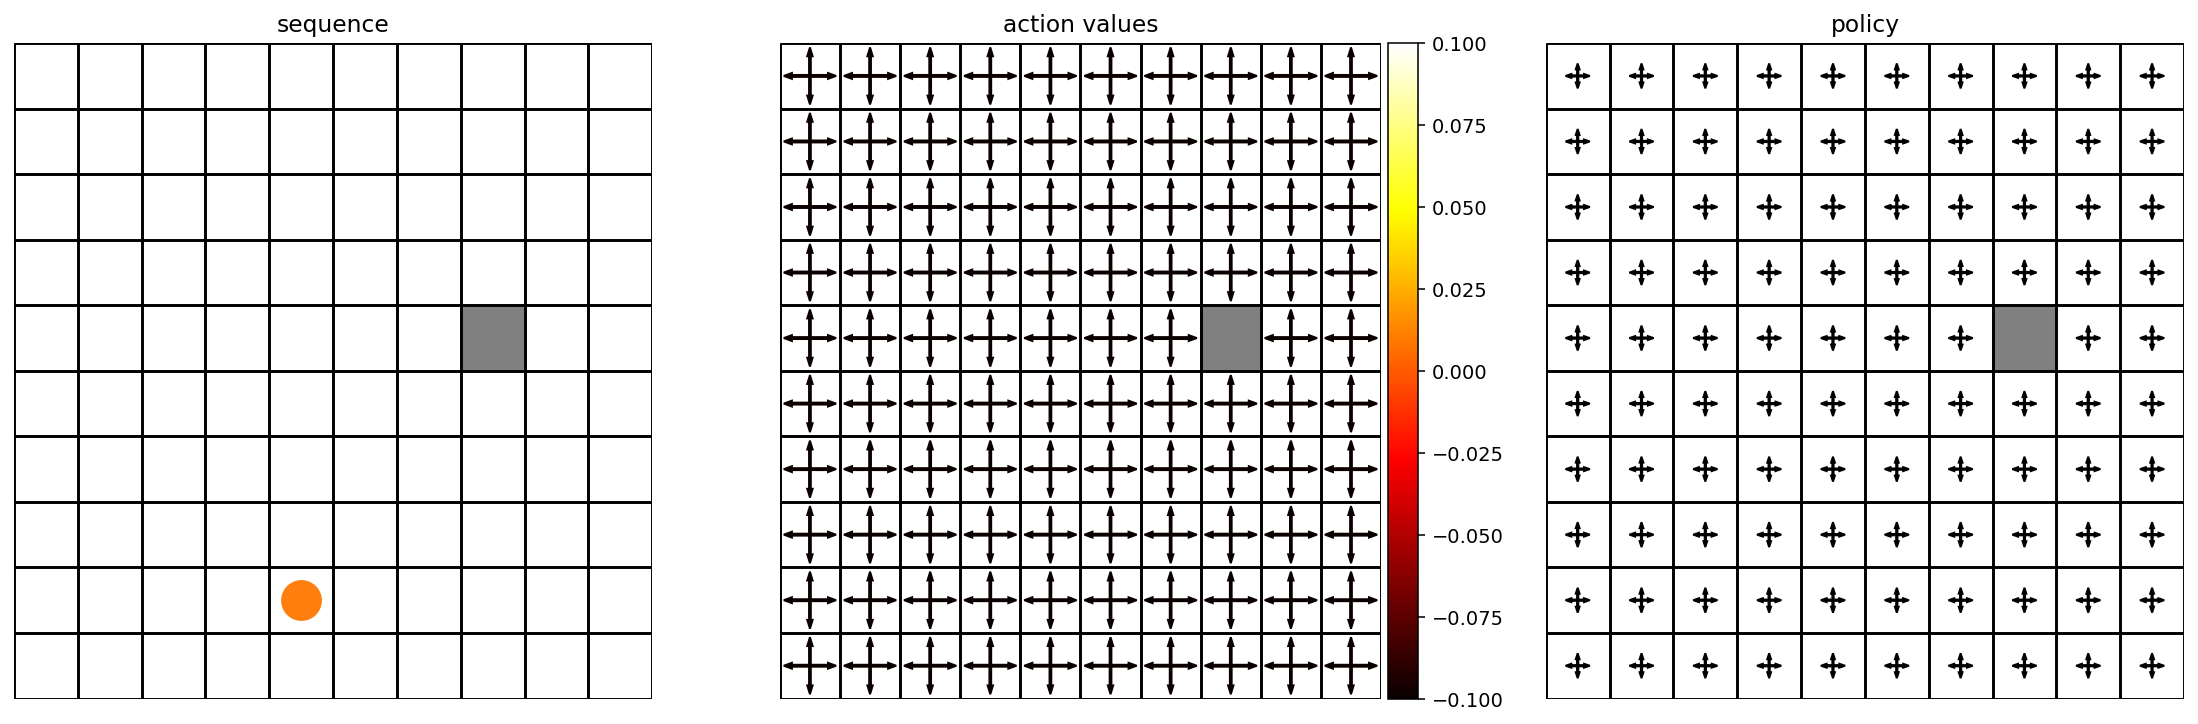

In [19]:
episode= []

# state = xy_to_state(0, 5)\
state = np.random.choice([state for state in range(N_states) if state not in target_states])
action = choose_action(policy, state)
episode.append((state, action, None))
#f = plot_method_step_with_only_state_values(episode, Q, policy)
f = plot_method_step_with_only_action_values(episode, Q, policy)
f.savefig(f'figures/first_episode_step_{len(episode)-1:03d}.png')
#display(f)
while True:
    print(len(episode), end=" ", flush=True)
    next_state, next_reward = next_state_and_reward(state, action)
    next_action = choose_action(policy, next_state)

    # compute update
    update = next_reward + gamma * Q[next_state, next_action] - Q[state, action]

    # update action value
    Q[state, action] += alpha * update

    # update policy
    update_policy_from_action_values(policy, Q, update_state=state, epsilon=epsilon)

    state = next_state
    action = next_action
    episode.append((next_state, next_action, next_reward))
    
    #f = plot_method_step_with_only_state_values(episode, Q, policy)
    f = plot_method_step_with_only_action_values(episode, Q, policy)
    f.savefig(f'figures/first_episode_step_{len(episode)-1:03d}.png')
    plt.close(f)
    clear_output()
    
    
    if state in target_states:
        break


In [59]:
#!ffmpeg -r 5 -start_number 2 -i first_episode_step_%03d.png -c:v libx264 -r 30 -pix_fmt yuv420p first_episode.mp4

In [60]:
episodes.append(episode)

### Run whole episode(s)

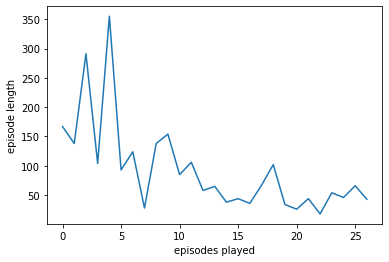

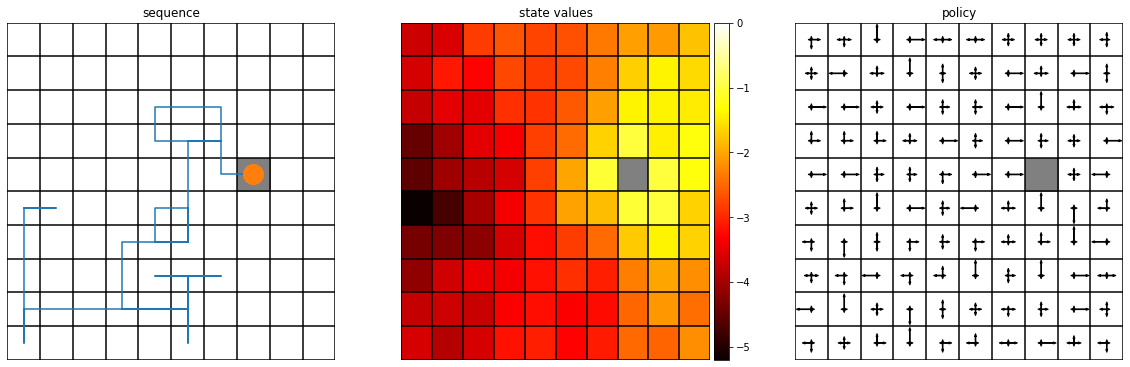

In [86]:
episode = []

state = xy_to_state(0, 5)
action = choose_action(policy, state)
episode.append((state, action, None))
while True:
    next_state, next_reward = next_state_and_reward(state, action)
    next_action = choose_action(policy, next_state)

    # compute update
    update = next_reward + gamma * Q[next_state, next_action] - Q[state, action]

    # update action value
    Q[state, action] += alpha * update

    # update policy
    update_policy_from_action_values(policy, Q, update_state=state, epsilon=epsilon)

    state = next_state
    action = next_action
    episode.append((next_state, next_action, next_reward))
    if state in target_states:
        break

episodes.append(episode)
if len(episodes) > 1:
    plt.plot([len(episode) for episode in episodes])
    plt.ylabel('episode length')
    plt.xlabel('episodes played')
    
plot_method_step_with_only_state_values(episode, Q, policy);

In [30]:
episodes = []

In [31]:
# Run one episode
for i in range(300):
    episode = []
    print(len(episodes), end=' ', flush=True)

    #state = xy_to_state(0, 5)
    state = np.random.choice([state for state in range(N_states) if state not in target_states])
    action = choose_action(policy, state)
    episode.append((state, action, None))
    while True:
        next_state, next_reward = next_state_and_reward(state, action)
        next_action = choose_action(policy, next_state)

        # compute update
        update = next_reward + gamma * Q[next_state, next_action] - Q[state, action]
        
        # update action value
        Q[state, action] += alpha * update
        
        # update policy
        update_policy_from_action_values(policy, Q, update_state=state, epsilon=epsilon)

        state = next_state
        action = next_action
        episode.append((next_state, next_action, next_reward))
        if state in target_states:
            break

    episodes.append(episode)
    f = plot_method_step_with_episodes(episodes, episode, Q, policy)
    #f = plot_method_step_with_episodes_state_values(episodes, episode, Q, policy)
    f.savefig(f'figures/episode_{len(episodes) - 1:05d}.png') 
    plt.close(f)
    
    #f = plot_method_step_with_episodes(episodes, episode, Q, policy)
    #f.savefig(f'Q_episode_{len(episodes) - 1:05d}.png') 
    #plt.close(f)
#if 
#if len(episodes) > 1:
#    plt.plot([len(episode) for episode in episodes])
#    plt.ylabel('episode length')
#    plt.xlabel('episodes played')\



0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

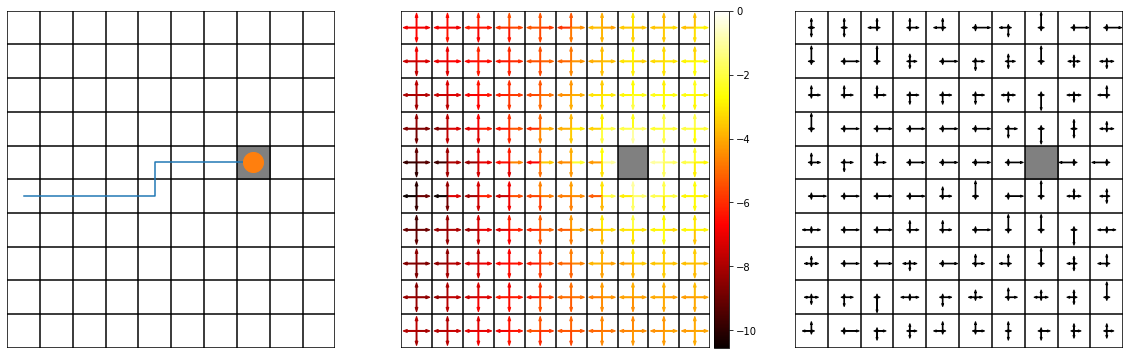

In [115]:
plot_method_step(episode, Q, policy)

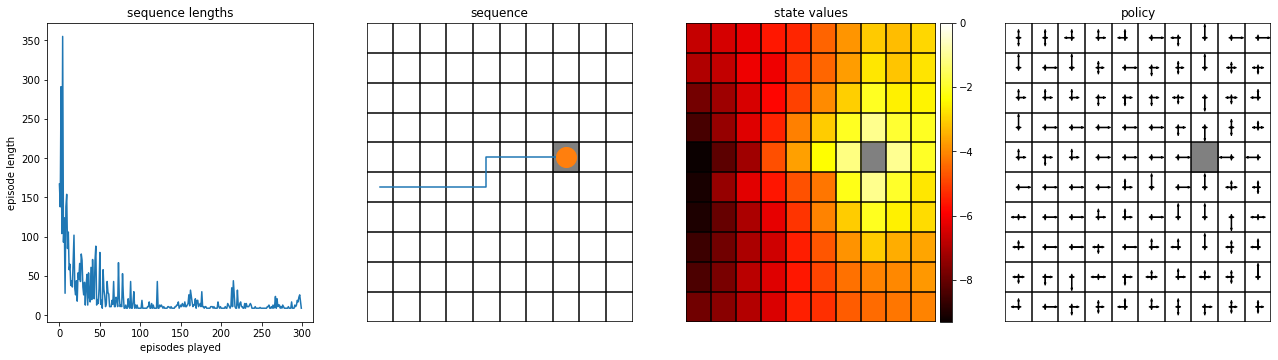

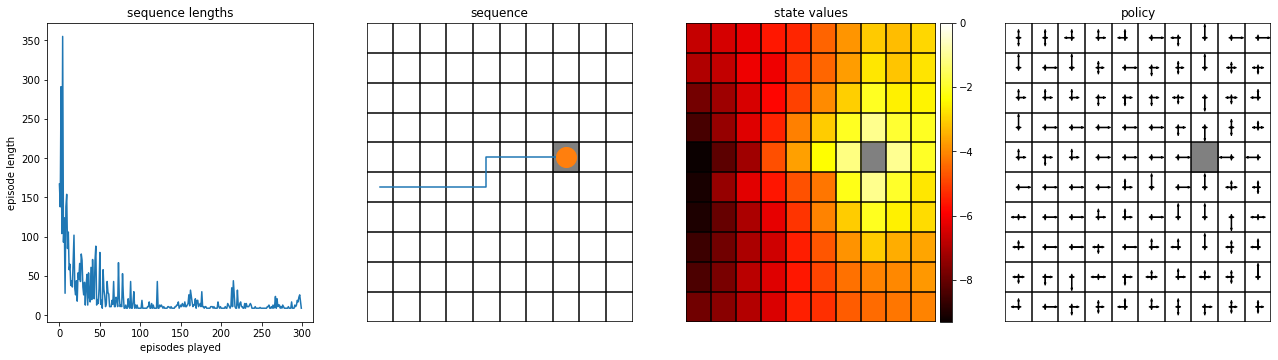

In [123]:
plot_method_step_with_episodes_state_values(episodes, episode, Q, policy)

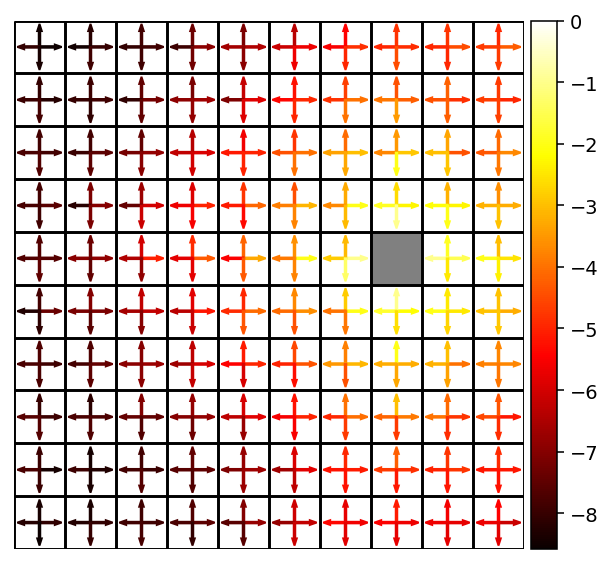

In [22]:
plt.figure(figsize=(5, 5))
plot_action_values(Q)

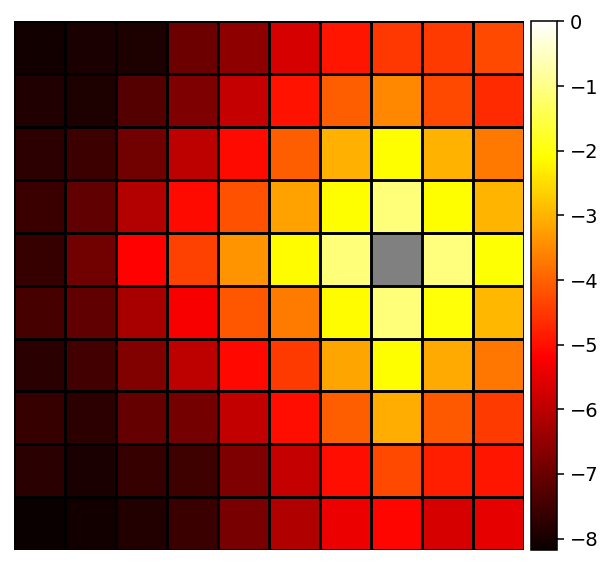

In [23]:
plt.figure(figsize=(5, 5))
plot_state_values(Q, policy)

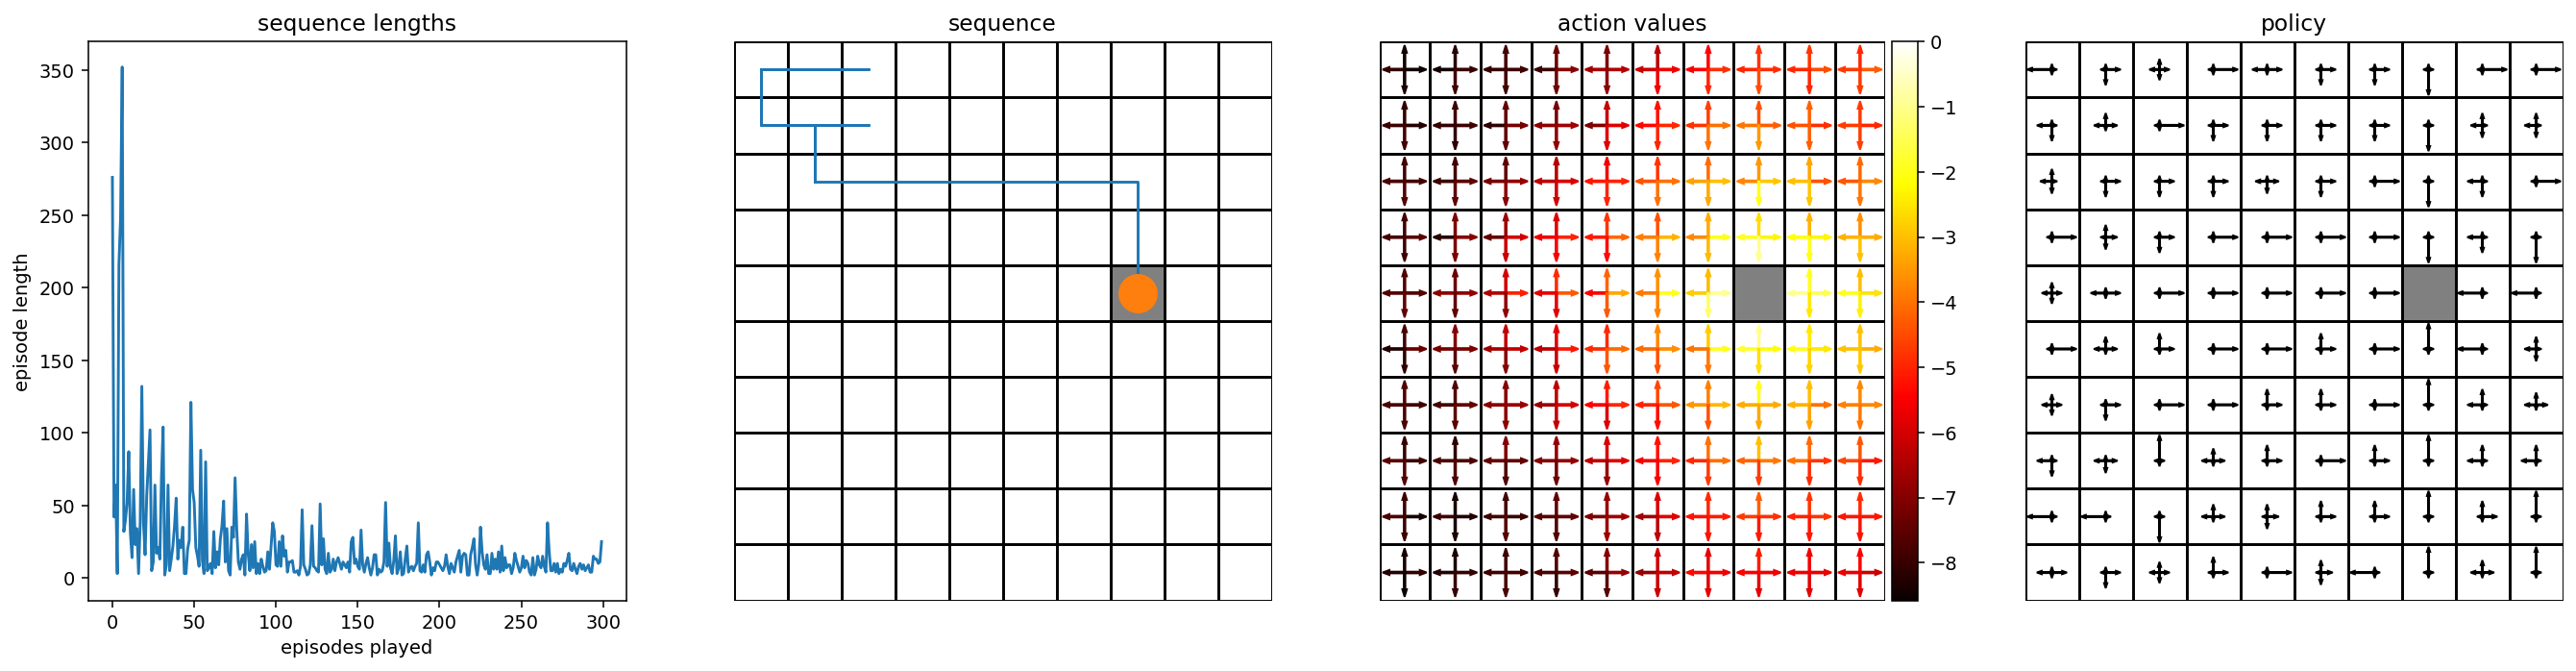

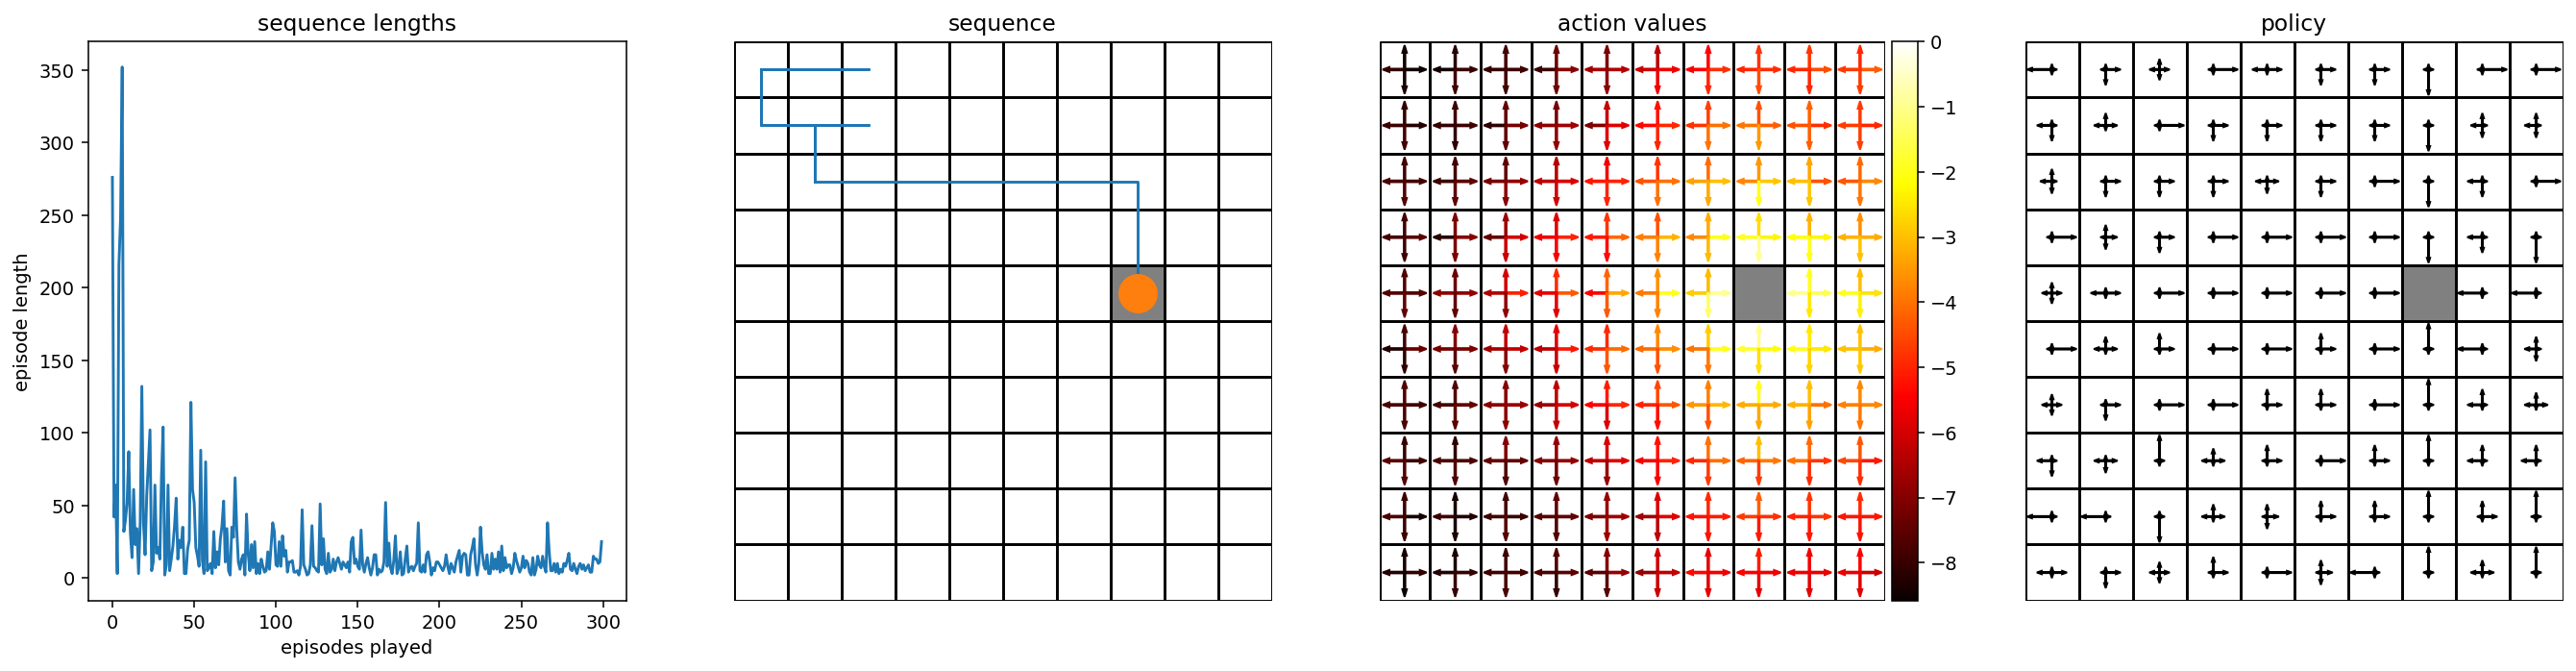

In [18]:
plot_method_step_with_episodes(episodes, episode, Q, policy)

## Let's add some wind

let's assume that in the lower area of our grid world an increasingly strong wind towards the right blows with offsets each movement according to the velocity of the wind

In [637]:
def next_state_and_reward(state, action):
    x, y = state_to_xy(state)
    dx, dy = actions[action]
    new_x = x + dx
    new_y = y + dy
    
    # add wind
    if new_x in [3, 4, 5, 8, 9]:
       new_y -= 1
    if new_x in [6, 7]:
       new_y -= 1
    
    # if new_y in [6]:
    #     new_x += 2
    # if new_y in [7]:
    #     new_x += 4
    # if new_y in [8, 9]:
    #     new_x += 4
    
    new_x = np.clip(new_x, 0, width - 1)
    new_y = np.clip(new_y, 0, height - 1)
    
    if (new_x, new_y) in target_states:
        reward = 0
    
    else:
        reward = -1
    
    new_state = xy_to_state(new_x, new_y)
    return new_state, reward

In [638]:
# SARSA
epsilon = 0.1
alpha = 0.1
gamma = 1

Q = np.zeros((N_states, N_actions))
#Q = np.random.randn(N_states, N_actions)
policy = update_policy_from_action_values(np.zeros_like(Q), Q, epsilon=epsilon)

In [656]:
episodes = []

(0.0, 115.0)

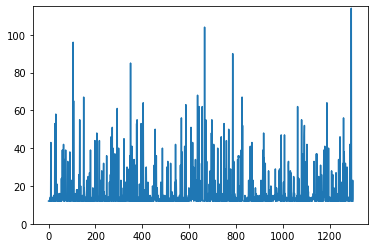

In [669]:
# Run one episode
for i in range(100):
    episode = []

    state = xy_to_state(0, 5)
    action = choose_action(policy, state)
    episode.append((state, action, None))
    while True:
        next_state, next_reward = next_state_and_reward(state, action)
        next_action = choose_action(policy, next_state)

        update = next_reward + gamma * Q[next_state, next_action] - Q[state, action]
        Q[state, action] += alpha * update
        update_policy_from_action_values(policy, Q, update_state=state, epsilon=epsilon)

        state = next_state
        action = next_action
        episode.append((next_state, next_action, next_reward))
        if state in target_states:
            break

    episodes.append(episode)

episode_lengths = [len(episode) for episode in episodes]
plt.plot(episode_lengths)
plt.ylim(0, max(episode_lengths[len(episode_lengths) // 2:]) + 1)
#plt.yscale('log')

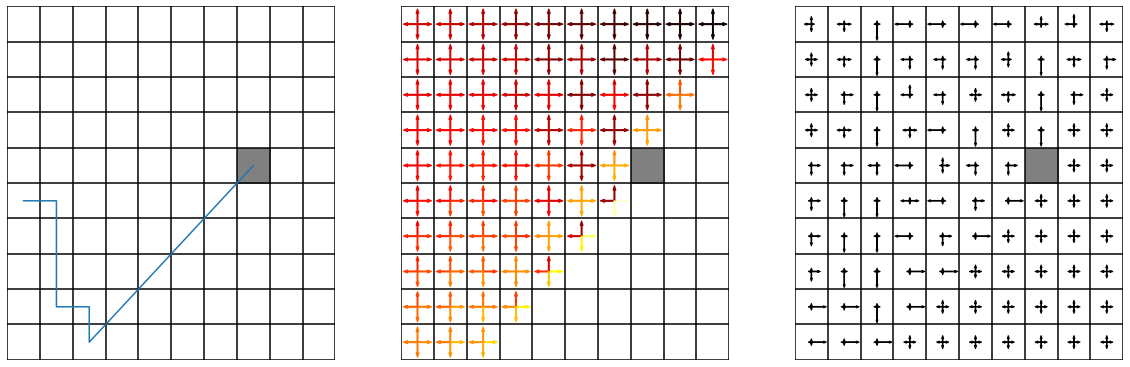

In [670]:
plot_method_step(episode, Q, policy)

In [529]:
len(episode)

205616

## Let's add some mudd

let's assume that in the lower area of our grid world an increasingly strong wind towards the right blows with offsets each movement according to the velocity of the wind

In [690]:
def next_state_and_reward(state, action):
    x, y = state_to_xy(state)
    dx, dy = actions[action]
    new_x = x + dx
    new_y = y + dy
    
    # add wind
    
        
    
    
    new_x = np.clip(new_x, 0, width - 1)
    new_y = np.clip(new_y, 0, height - 1)
    
    if (new_x, new_y) in target_states:
        reward = 0
    elif new_x in [2, 3, 4, 5] and new_y in [3, 4, 5]:
        reward = -5
    
    else:
        reward = -1
    
    new_state = xy_to_state(new_x, new_y)
    return new_state, reward

In [691]:
# SARSA
epsilon = 0.1
alpha = 0.5
gamma = 1

Q = np.zeros((N_states, N_actions))
#Q = np.random.randn(N_states, N_actions)
policy = update_policy_from_action_values(np.zeros_like(Q), Q, epsilon=epsilon)

In [692]:
episodes = []

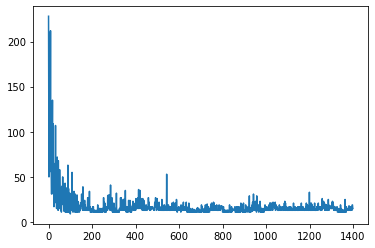

In [707]:
# Run one episode
for i in range(100):
    episode = []

    state = xy_to_state(0, 5)
    action = choose_action(policy, state)
    episode.append((state, action, None))
    while True:
        next_state, next_reward = next_state_and_reward(state, action)
        next_action = choose_action(policy, next_state)

        update = next_reward + gamma * Q[next_state, next_action] - Q[state, action]
        Q[state, action] += alpha * update
        update_policy_from_action_values(policy, Q, update_state=state, epsilon=epsilon)

        state = next_state
        action = next_action
        episode.append((next_state, next_action, next_reward))
        if state in target_states:
            break

    episodes.append(episode)

episode_lengths = [len(episode) for episode in episodes]
plt.plot(episode_lengths)
#plt.ylim(0, max(episode_lengths[len(episode_lengths) // 2:]) + 1)
#plt.yscale('log')

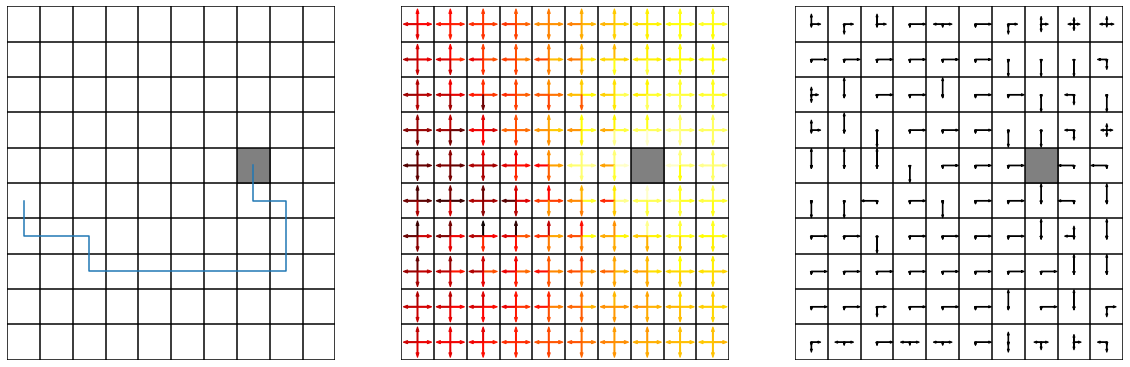

In [709]:
pure_policy = update_policy_from_action_values(np.zeros_like(policy), Q)
plot_method_step(episode, Q, pure_policy)

# Backup code

### Run episode step by step

In [77]:
# initialize episode
episode = []
state = xy_to_state(0, 5)
action = choose_action(policy, state)
episode.append((state, action, None))

In [112]:
next_state, next_reward = next_state_and_reward(state, action)
next_action = choose_action(policy, next_state)

update = next_reward + gamma * Q[next_state, next_action] - Q[state, action]
Q[state, action] += alpha * update
update_policy_from_action_values(policy, Q, update_state=state, epsilon=epsilon)

state = next_state
action = next_action
episode.append((next_state, next_action, next_reward))
if state in target_states:
    print("reached target")

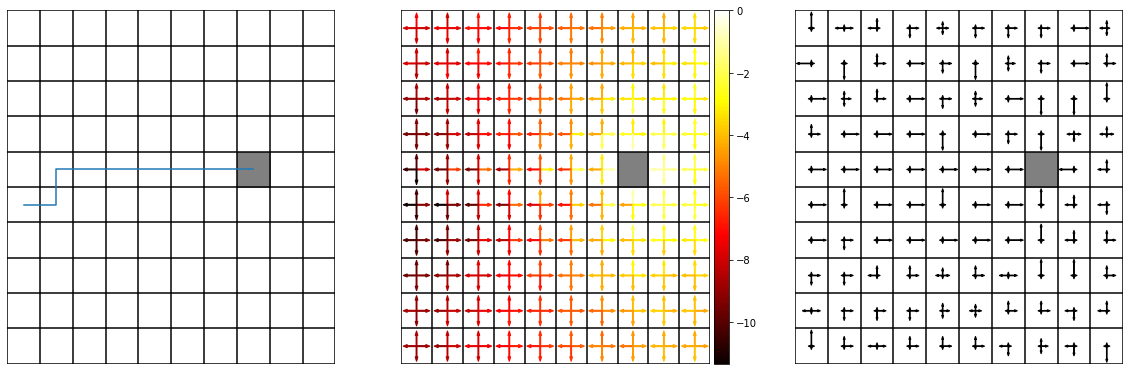

In [147]:
plot_method_step(episode, Q, policy)